<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Tumor_Classification_Using_RGB_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models

Load the preprocessed dataset

In [2]:
# Define the dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classification"

EDA

In [3]:
# Exploratory Data Analysis (EDA)
def perform_eda(images, labels, class_names):
    """Perform EDA on the dataset."""
    import pandas as pd

    # 1. Dataset Overview
    print("\n--- Dataset Overview ---")
    print(f"Total Images: {len(images)}")
    print(f"Total Classes: {len(class_names)}")
    print(f"Class Distribution: {np.bincount(labels)}")
    print("\nClass Names with Distribution:")
    class_distribution = pd.DataFrame({"Class": class_names, "Count": np.bincount(labels)})
    print(class_distribution)

    # 2. Visualize Class Distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

    # 3. Display Sample Images from Each Class
    print("\n--- Displaying Sample Images from Each Class ---")
    plt.figure(figsize=(24, 24))
    for i, class_name in enumerate(class_names):
        idx = labels.tolist().index(i)  # Get the first image index for this class
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 4. Image Shape and Value Distribution
    print("\n--- Image Shape and Value Distribution ---")
    print(f"Image Shape: {images[0].shape}")
    print(f"Pixel Intensity Range: Min = {np.min(images)}, Max = {np.max(images)}")
    plt.figure(figsize=(12, 5))
    plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

    # 5. Check for Class Imbalance
    print("\n--- Checking Class Imbalance ---")
    class_imbalance = np.bincount(labels)
    max_samples = max(class_imbalance)
    imbalance_ratio = max_samples / class_imbalance
    print(f"Imbalance Ratio: {imbalance_ratio}")
    if any(imbalance_ratio > 1.5):
        print("Warning: Dataset has class imbalance.")


Function to load the dataset

In [4]:
def load_dataset(base_dir):
    """Load the dataset, preprocess images, convert grayscale to RGB, and return data and labels."""
    images, labels = [], []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    # Load the image in grayscale
                    image = tf.io.read_file(file_path)
                    image = tf.image.decode_image(image, channels=1)  # Load as grayscale
                    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
                    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
                    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

                    images.append(image.numpy())
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Could not process {file_path}: {e}")

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    # Display a sample image to confirm RGB conversion
    if len(images) > 0:
        plt.imshow(images[0])  # Matplotlib assumes (H, W, 3) as RGB
        plt.title(f"Sample Image (Class: {class_names[labels[0]]})")
        plt.axis("off")
        plt.show()

    return images, labels, class_names


Split the dataset

Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']


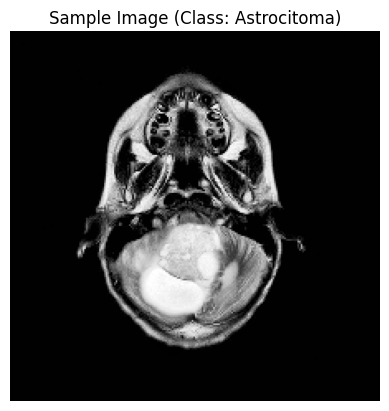

Training Images Shape: (22400, 224, 224, 3)
Training Labels Shape: (22400,)


In [5]:
# Load and split the dataset
images, labels, class_names = load_dataset(base_dir) # Assign class_names
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

print (f"Training Images Shape: {train_images.shape}")
print (f"Training Labels Shape: {train_labels.shape}")

Visualize EDA


--- Dataset Overview ---
Total Images: 32000
Total Classes: 16
Class Distribution: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000]

Class Names with Distribution:
                Class  Count
0         Astrocitoma   2000
1           Carcinoma   2000
2          Ependimoma   2000
3       Ganglioglioma   2000
4           Germinoma   2000
5        Glioblastoma   2000
6           Granuloma   2000
7      Meduloblastoma   2000
8         Neurocitoma   2000
9   Oligodendroglioma   2000
10           Papiloma   2000
11         Schwannoma   2000
12        Tuberculoma   2000
13         meningioma   2000
14          no tumour   2000
15          pituitary   2000


<ipython-input-3-5256aea907db>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")


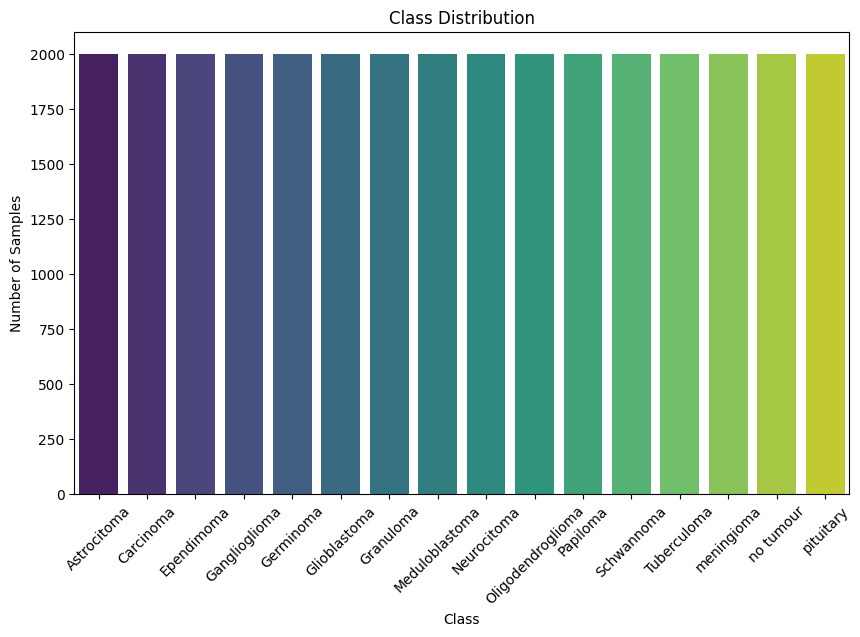


--- Displaying Sample Images from Each Class ---


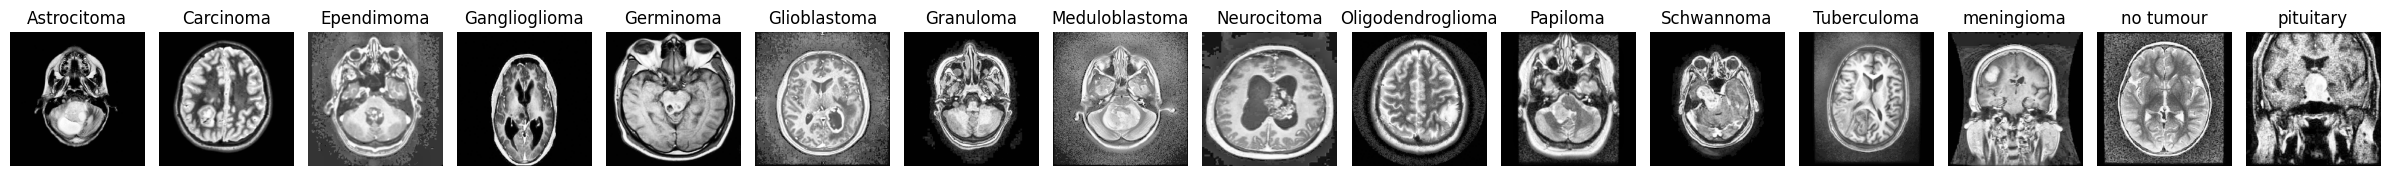


--- Image Shape and Value Distribution ---
Image Shape: (224, 224, 3)
Pixel Intensity Range: Min = 0.0, Max = 1.0


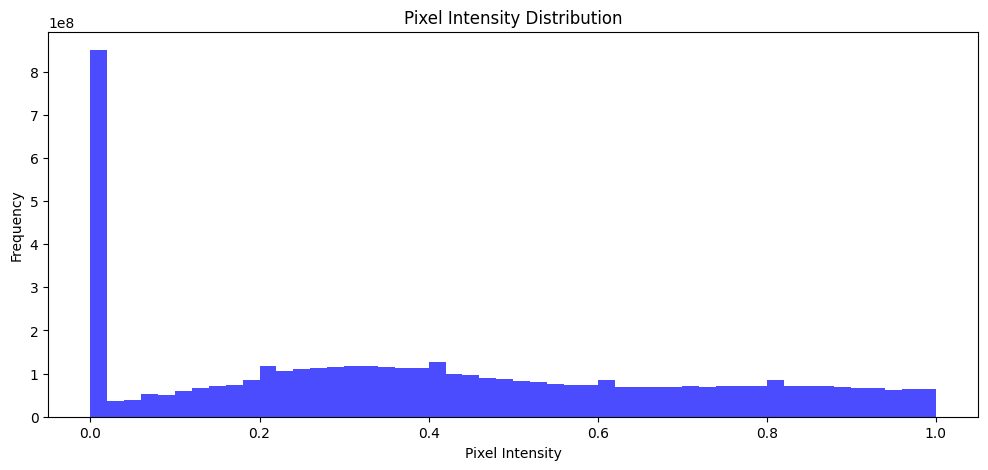


--- Checking Class Imbalance ---
Imbalance Ratio: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
# Perform EDA on the dataset
perform_eda(images, labels, class_names)

Create the Vision Transformer model (ViT)

In [10]:
def create_vit_model(input_shape, num_classes, patch_size=32, embed_dim=64, num_heads=4, transformer_layers=4):
    """Build a Vision Transformer (ViT) model."""

    inputs = layers.Input(shape=input_shape)

    # Patch Embedding: Convert images into patch embeddings
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((-1, embed_dim))(patch_projection)

    # Learnable positional embeddings (ensure it's part of the model graph)
    positional_embedding = tf.Variable(tf.random.normal([1, num_patches, embed_dim]), trainable=True)
    x = patches + positional_embedding  # Broadcasts across batch dimension


    # Transformer Layers
    for _ in range(transformer_layers):
        # Layer Normalization before attention (Pre-Norm)
        x_norm1 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x_norm1, x_norm1)
        x = layers.Add()([x, attention_output])  # Residual connection

        # Layer Normalization before feed-forward (Pre-Norm)
        x_norm2 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        ff_output = layers.Dense(embed_dim * 2, activation='relu')(x_norm2)
        ff_output = layers.Dense(embed_dim)(ff_output)
        x = layers.Add()([x, ff_output])  # Residual connection

    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)  # Alternative to class token
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
# Create the model
input_shape = (224, 224, 3)
num_classes = len(np.unique(labels))
model = create_vit_model(input_shape, num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 64)       │        196,672 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 49, 64)         │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 49, 64)         │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 49, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 49, 64)         │         16,640 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 49, 64)         │              0 │ add[0][0],             │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 49, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 49, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 49, 64)         │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 49, 64)         │              0 │ add_1[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 49, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 49, 64)         │         16,640 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 49, 64)         │              0 │ add_2[0][0],           │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 49, 64)         │            128 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 341,072 (1.30 MB)

 Trainable params: 341,072 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np
from tensorflow.keras import layers, models

# Step 1: Define the Vision Transformer (ViT) Model
def create_vit_model(input_shape, num_classes, patch_size=32, embed_dim=64, num_heads=4, transformer_layers=4):
    """Build a Vision Transformer (ViT) model."""

    inputs = layers.Input(shape=input_shape)

    # Patch Embedding: Convert images into patch embeddings
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((-1, embed_dim))(patch_projection)

    # Learnable positional embeddings (ensure it's part of the model graph)
    positional_embedding = tf.Variable(tf.random.normal([1, num_patches, embed_dim]), trainable=True)
    x = patches + positional_embedding  # Broadcasts across batch dimension

    # Transformer Layers
    for _ in range(transformer_layers):
        # Layer Normalization before attention (Pre-Norm)
        x_norm1 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x_norm1, x_norm1)
        x = layers.Add()([x, attention_output])  # Residual connection

        # Layer Normalization before feed-forward (Pre-Norm)
        x_norm2 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        ff_output = layers.Dense(embed_dim * 2, activation='relu')(x_norm2)
        ff_output = layers.Dense(embed_dim)(ff_output)
        x = layers.Add()([x, ff_output])  # Residual connection

    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)  # Alternative to class token
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Step 2: Define Hyperparameter Search Function
def build_model(hp):
    input_shape = (224, 224, 3)
    num_classes = len(np.unique(labels))

    # Define tunable hyperparameters
    patch_size = hp.Choice('patch_size', [16, 32, 64])  # Patch sizes
    embed_dim = hp.Choice('embed_dim', [64, 128, 256])  # Embedding dimensions
    num_heads = hp.Choice('num_heads', [2, 4, 8])  # Attention heads
    transformer_layers = hp.Int('transformer_layers', min_value=2, max_value=6, step=1)  # Number of transformer layers
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)  # Dropout rate

    model = create_vit_model(input_shape, num_classes, patch_size, embed_dim, num_heads, transformer_layers)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 3: Run Hyperparameter Search
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter sets to try
    executions_per_trial=1,
    directory='hyperparam_search',
    project_name='vit_tuning'
)

tuner.search(train_images, train_labels,
             validation_data=(test_images, test_labels),
             epochs=10,
             batch_size=kt.HyperParameters().Choice('batch_size', [8, 16, 32]))

# Step 4: Train the Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Best Hyperparameters Found:")
print(f" - Patch Size: {best_hps.get('patch_size')}")
print(f" - Embedding Dimension: {best_hps.get('embed_dim')}")
print(f" - Number of Heads: {best_hps.get('num_heads')}")
print(f" - Transformer Layers: {best_hps.get('transformer_layers')}")
print(f" - Dropout Rate: {best_hps.get('dropout')}")
print(f" - Learning Rate: {best_hps.get('learning_rate')}")
print(f" - Optimizer: {best_hps.get('optimizer')}")
print(f" - Batch Size: {best_hps.get('batch_size')}")

history = best_model.fit(train_images, train_labels,
                         validation_data=(test_images, test_labels),
                         epochs=70, batch_size=best_hps.get('batch_size'))


Reloading Tuner from hyperparam_search/vit_tuning/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters Found:
 - Patch Size: 64
 - Embedding Dimension: 64
 - Number of Heads: 8
 - Transformer Layers: 2
 - Dropout Rate: 0.30000000000000004
 - Learning Rate: 0.0001
 - Optimizer: adam


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=70, batch_size=8)

Epoch 1/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - accuracy: 0.1038 - loss: 2.7068 - val_accuracy: 0.2274 - val_loss: 2.3256
Epoch 2/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.2532 - loss: 2.2796 - val_accuracy: 0.4227 - val_loss: 1.8159
Epoch 3/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.4277 - loss: 1.7450 - val_accuracy: 0.5464 - val_loss: 1.3540
Epoch 4/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.5439 - loss: 1.3934 - val_accuracy: 0.6525 - val_loss: 1.0794
Epoch 5/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.6232 - loss: 1.1277 - val_accuracy: 0.6927 - val_loss: 0.9017
Epoch 6/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.6905 - loss: 0.9285 - val_accuracy: 0.7764 - val_loss: 0.6762
Epoch 7/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7421 - loss: 0.7855 - val_accuracy: 0.7972 - val_loss: 0.6085
Epoch 8/70
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7919 - loss: 

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       600
           1       1.00      1.00      1.00       600
           2       1.00      0.98      0.99       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600
           6       0.98      1.00      0.99       600
           7       0.99      1.00      0.99       600
           8       0.98      0.99      0.98       600
           9       1.00      0.95      0.97       600
          10       0.99      0.99      0.99       600
          11       0.99      0.98      0.98       600
          12       1.00      1.00      1.00       600
          13       0.91      0.93      0.92       600
          14       0.94      0.92      0.93       600
          15       0.99      0.94      0.96       600

    accuracy                           0.98      9600
   

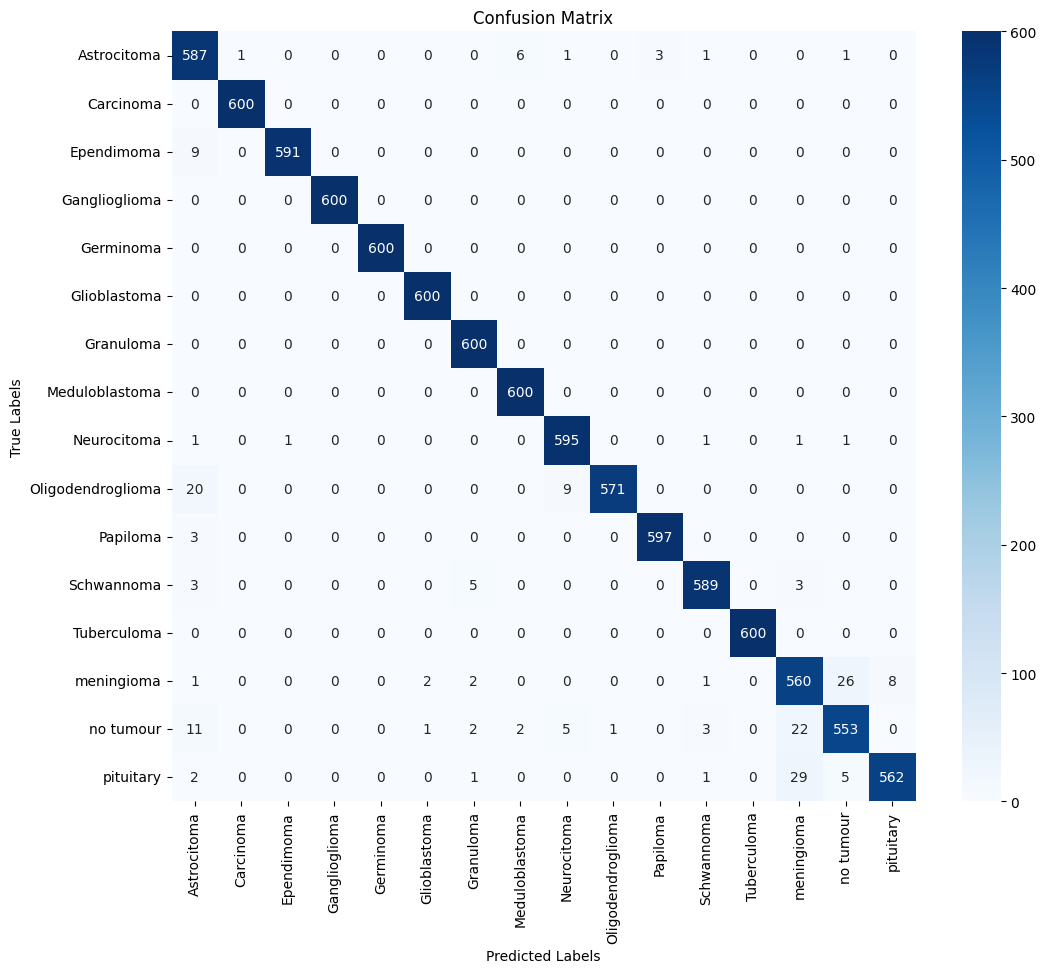

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


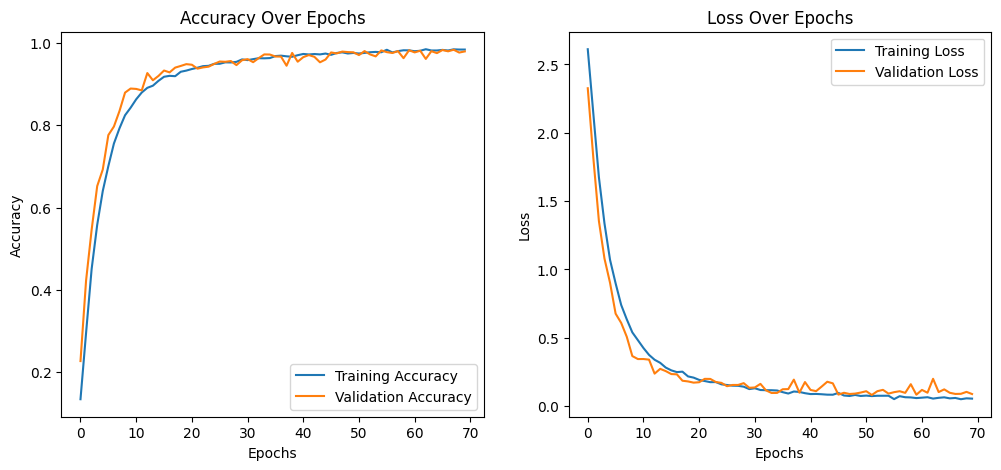

In [ ]:
# Plot Training and Validation Metrics
def plot_metrics(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)


Average Classification Time per Tumor Class:
Class 0: 0.085929 seconds
Class 1: 0.085413 seconds
Class 2: 0.085505 seconds
Class 3: 0.087297 seconds
Class 4: 0.085994 seconds
Class 5: 0.085728 seconds
Class 6: 0.085954 seconds
Class 7: 0.085491 seconds
Class 8: 0.085724 seconds
Class 9: 0.086084 seconds
Class 10: 0.086461 seconds
Class 11: 0.086378 seconds
Class 12: 0.089566 seconds
Class 13: 0.087193 seconds
Class 14: 0.085890 seconds
Class 15: 0.086550 seconds


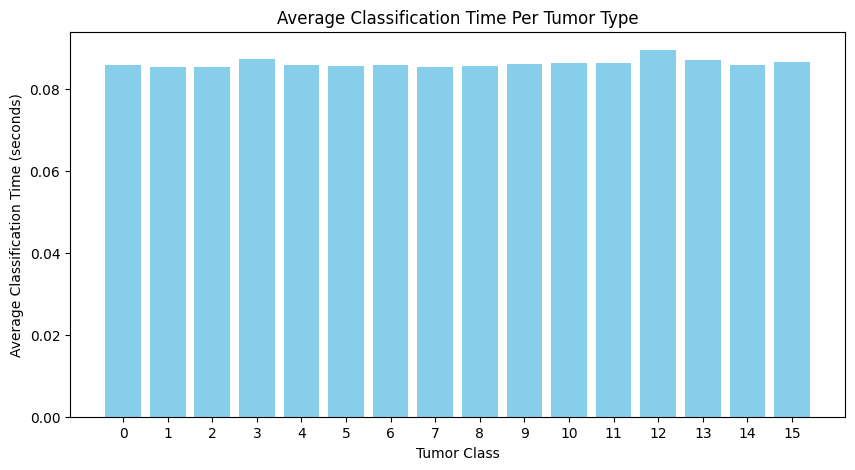

In [ ]:
import time

# Dictionary to store time taken for each class
class_time = {label: [] for label in np.unique(labels)}

# Measure classification time for each test sample
for i, img in enumerate(test_images):
    start_time = time.time()  # Start timer
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)  # Get prediction
    end_time = time.time()  # End timer

    elapsed_time = end_time - start_time  # Compute time taken
    true_class = test_labels[i]  # Get true class label
    class_time[true_class].append(elapsed_time)  # Store time taken

# Compute average classification time per class
avg_time_per_class = {label: np.mean(times) for label, times in class_time.items()}

# Print results
print("\nAverage Classification Time per Tumor Class:")
for label, time_taken in avg_time_per_class.items():
    print(f"Class {label}: {time_taken:.6f} seconds")

# Plot classification time per class
plt.figure(figsize=(10, 5))
plt.bar(avg_time_per_class.keys(), avg_time_per_class.values(), color='skyblue')
plt.xlabel("Tumor Class")
plt.ylabel("Average Classification Time (seconds)")
plt.title("Average Classification Time Per Tumor Type")
plt.xticks(ticks=np.unique(labels))  # Set x-axis labels
plt.show()


In [ ]:
#Save the model
model.save("/content/drive/MyDrive/Colab Notebooks/ViT_model_RGB_new.keras")
